In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import os, re
import numpy as np
from scipy.stats import mode

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, Imputer
from sklearn.svm import SVR
from itertools import izip_longest

In [10]:
high = []
low = []
some_dataframe = []
all_dataframes = []
for root, dirs, files in os.walk("./trajectories"):  
    for filename in files:
        conductivity = re.search("[^h](\d{2,3})",filename).group(1) 
        print './trajectories/' + filename
        dataset = np.genfromtxt('./trajectories/' + filename, delimiter=",")
        size = dataset.shape[0]
        all_dataframes.append(dataset)
        if conductivity == "200":
            high.append(size)
            some_dataframe.append(dataset)
        else:
            low.append(size)
len(all_dataframes)

./trajectories/Fish8 NE1 C200_clean.csv
./trajectories/Fish17 NE2 C30_clean.csv
./trajectories/Fish9 NE1 C30_clean.csv
./trajectories/Fish16 NE2 C200_clean.csv
./trajectories/Fish12 NE2 C200_clean.csv
./trajectories/Fish3 NE2 C30_clean.csv
./trajectories/Fish8 NE2 C30_clean.csv
./trajectories/Fish4 NE2 C30_clean.csv
./trajectories/Fish4 NE1 C200_clean.csv
./trajectories/Fish21 NE2 C200 take2_clean.csv
./trajectories/Fish18 NE1 C200_clean.csv
./trajectories/Fish1 NE2 C200_clean.csv
./trajectories/Fish5 NE2 C30_clean.csv
./trajectories/Fish21 NE1 C30_clean.csv
./trajectories/Fish2 NE2 C200_clean.csv
./trajectories/Fish7 NE1 C30_clean.csv
./trajectories/Fish13 NE2 C200_clean.csv
./trajectories/Fish6 NE2 C200_clean.csv
./trajectories/Fish10 NE1 C200_clean.csv
./trajectories/Fish11 NE2 C30_clean.csv
./trajectories/Fish10 NE2 C30_clean.csv
./trajectories/Fish15 NE1 C30_clean.csv
./trajectories/Fish16 NE1 C30_clean.csv
./trajectories/Fish19 NE1 C200_clean.csv
./trajectories/Fish7 NE2 C200_cle

42

In [11]:
len(high), len(low)

(22, 20)

In [12]:
sum(high), sum(low)

(543551, 514307)

In [13]:
count = 0
remove_last = []
for a in (np.c_[high]%999.0):
    if a < 500 and a != 0:
        remove_last.append(count)
    count+=1
remove_last, np.c_[high]/999.0

([10, 11], array([[ 27.        ],
        [ 27.        ],
        [ 27.        ],
        [  4.91891892],
        [ 27.        ],
        [ 27.        ],
        [ 27.        ],
        [ 27.        ],
        [ 27.        ],
        [ 27.        ],
        [ 26.4004004 ],
        [ 22.05005005],
        [ 27.        ],
        [ 27.        ],
        [ 27.        ],
        [ 27.        ],
        [ 27.        ],
        [ 27.        ],
        [ 27.        ],
        [  4.72572573],
        [ 27.        ],
        [ 27.        ]]))

In [14]:
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx
    args = [iter(iterable)] * n
    return izip_longest(fillvalue=fillvalue, *args)

In [25]:
h = some_dataframe[2]
a = np.asarray(list(grouper(list(h), 999, [0,0])))
a.shape

(27, 999, 2)

In [26]:
imp = Imputer(missing_values=0,strategy="mean", copy=True)
imp.fit(a[-1])

Imputer(axis=0, copy=True, missing_values=0, strategy='mean', verbose=0)

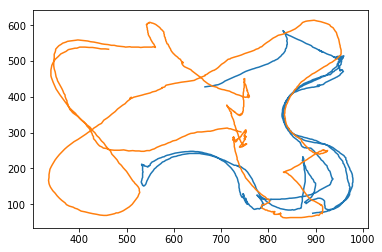

In [27]:
finished_dataframe = imp.transform(a[-1])
plt.plot(finished_dataframe[:,0], finished_dataframe[:,1])
comparison = np.asarray(a[0])
plt.plot(comparison[:,0], comparison[:,1])

This shows the difference between two models of the same label (high conductivity), one that is filled via mean imputation (original size 725) and one that is complete (size 999)

In [30]:
def fill_missing(dataset):
    imp = Imputer(missing_values=0,strategy="mean", copy=True)
    return imp.fit_transform(dataset)

In [31]:
fill_missing(a[-1])

array([[ 666.,  428.],
       [ 671.,  429.],
       [ 677.,  430.],
       ..., 
       [ 903.,   77.],
       [ 899.,   76.],
       [ 894.,   75.]])

In [32]:
def split_dataframe(data, split_size=999, threshold=400):
    remainder = data.shape[0] % split_size
    splitted_data = list(grouper(data, split_size, [0,0]))
    splitted_data = np.asarray(splitted_data)
    if remainder < threshold: #if there is less than 400 data points in the last set of the splitted data
        splitted_data = np.delete(splitted_data, -1, 0) #delete the last set
    #elif remainder != 0: #if there are more than 400 data points and less than the split size
    #    splitted_data[-1] = fill_missing(splitted_data[-1])
    return splitted_data

In [33]:
print(np.concatenate((split_dataframe(some_dataframe[2]), split_dataframe(some_dataframe[6])), axis=0).shape)
ds = [split_dataframe(some_dataframe[2]), split_dataframe(some_dataframe[6])]
print np.concatenate(tuple(ds)).shape

(52, 999, 2)
(52, 999, 2)


In [34]:
def split_and_combine_splits(dataframes):
    temp = dataframes
    dataframes[:] = [split_dataframe(np.asarray(dataframe)) for dataframe in dataframes]
    print(dataframes == temp)
    dataframes_as_tuples = tuple(dataframes)
    
    return np.concatenate(dataframes_as_tuples, axis=0)

In [35]:
complete_dataset = split_and_combine_splits(all_dataframes)

True


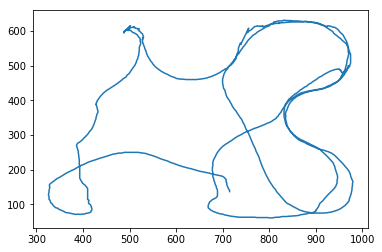

In [36]:
plt.plot(complete_dataset[-21][:,0], complete_dataset[-21][:,1])

In [37]:
complete_dataset.shape

(1026, 999, 2)

In [38]:
np.save("./Experiments/trajectory_v_math/train/pos_set", complete_dataset)

In [26]:
for index,trajectory in zip(range(complete_dataset.shape[0]),complete_dataset):
    np.savetxt("./Experiments/trajectory_v_math/train/pos_set/file_[%s].csv" % index, trajectory, delimiter=",")